# Preproceeseing

In [1]:
from nba_api.stats.endpoints import PlayerGameLogs, LeagueStandingsV3
from nba_api.stats.static import players, teams

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)

In [2]:
def make_last (l1, df):
    cols = list(df.columns)
    for col in l1:
        cols.remove(col)
        cols.append(col)
    df = df[cols]
    return df


def add_target(group):
    group["target"] = group["won"].shift(-1)
    group["target"].fillna(2, inplace=True)
    return group


def check_data_quality(df):
    print("The shape:")
    print(df.shape)

    
    missing_values = df.isna().sum()
    if missing_values.sum() == 0:
        print("\nNo missing values found.")
    else:
        print("Columns with missing values:")
        print(missing_values[missing_values != 0])

    print("\nData types:")
    print(df.dtypes)
    
    print("\nUnique types:")
    print(df.nunique())

    print("\nSummary Statistics:")
    df.describe()

    df.hist(bins=50, figsize=(20,15))

The shape:
(171734, 68)

No missing values found.

Data types:
SEASON_YEAR              object
PLAYER_ID                 int64
PLAYER_NAME              object
NICKNAME                 object
TEAM_ID                   int64
                          ...  
NBA_FANTASY_PTS_RANK      int64
DD2_RANK                  int64
TD3_RANK                  int64
WNBA_FANTASY_PTS_RANK     int64
VIDEO_AVAILABLE_FLAG      int64
Length: 68, dtype: object

Unique types:
SEASON_YEAR                 7
PLAYER_ID                1161
PLAYER_NAME              1161
NICKNAME                  717
TEAM_ID                    30
                         ... 
NBA_FANTASY_PTS_RANK     3910
DD2_RANK                    8
TD3_RANK                    8
WNBA_FANTASY_PTS_RANK     511
VIDEO_AVAILABLE_FLAG        3
Length: 68, dtype: int64

Summary Statistics:


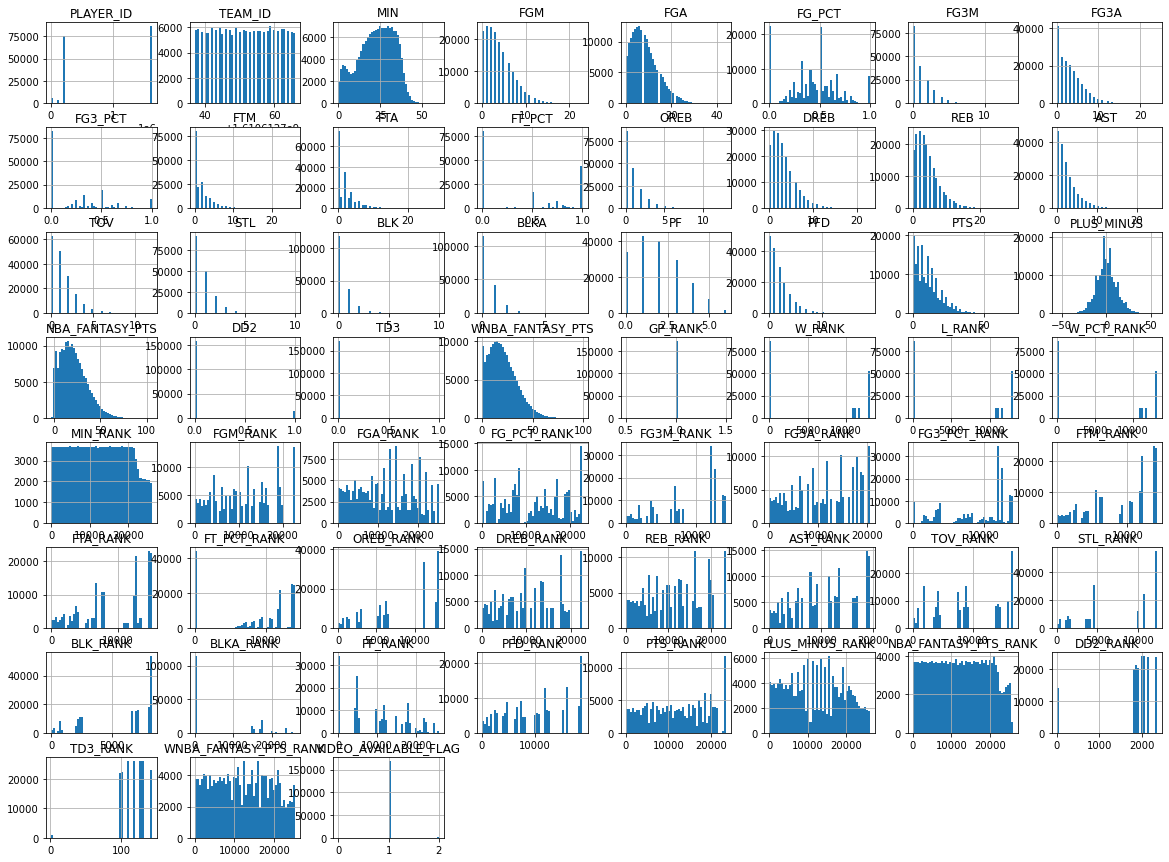

In [3]:
def mergeDbStats(year, df):
    df_stats_new = PlayerGameLogs(season_nullable=year).get_data_frames()[0]
    df = pd.concat([df_stats_new, df], ignore_index=True)
    return df

    
    
    
df_stats_all_years = PlayerGameLogs(season_nullable='2016-17').get_data_frames()[0]
df_stats_all_years = mergeDbStats('2017-18', df_stats_all_years)
df_stats_all_years = mergeDbStats('2018-19', df_stats_all_years)
df_stats_all_years = mergeDbStats('2019-20', df_stats_all_years)
df_stats_all_years = mergeDbStats('2020-21', df_stats_all_years)
df_stats_all_years = mergeDbStats('2021-22', df_stats_all_years)
df_stats_all_years = mergeDbStats('2022-23', df_stats_all_years)

check_data_quality(df_stats_all_years) 

In [4]:
df_player_preprocess = df_stats_all_years

In [5]:
df_player_preprocess["VIDEO_AVAILABLE_FLAG"] = df_player_preprocess['MATCHUP'].str.split(' ', n = 2, expand = True)[2]
df_player_preprocess.rename(columns={"VIDEO_AVAILABLE_FLAG": "team_opp"}, inplace=True)

del df_player_preprocess["MATCHUP"]


df_player_preprocess["GAME_DATE"] = df_player_preprocess['GAME_DATE'].str.split('T', n = 2, expand = True)[0]


WL = df_player_preprocess['WL']
del df_player_preprocess["WL"]
WL = WL.map({'W': 1, 'L': 0, np.nan: 2})
df_player_preprocess["won"] = WL


df_player_preprocess = df_player_preprocess.sort_values("GAME_DATE")


df_player_preprocess = df_player_preprocess.groupby("PLAYER_ID", group_keys=False).apply(add_target)


del df_player_preprocess['PLAYER_ID']
del df_player_preprocess['NICKNAME']
del df_player_preprocess['TEAM_NAME']
del df_player_preprocess['TEAM_ID']
del df_player_preprocess['GAME_ID']


df_player_preprocess = df_player_preprocess.rename(columns={'TEAM_ABBREVIATION': 'team'})
df_player_preprocess = df_player_preprocess.rename(columns={'PLAYER_NAME': 'player'})
df_player_preprocess = df_player_preprocess.rename(columns={'SEASON_YEAR': 'season'})


df_player_preprocess = make_last(list(['season', 'player', 'team', 'GAME_DATE']), df_player_preprocess)


print('WON columns value counts:')
print(df_player_preprocess["won"].value_counts())
print('\nTARGET column value counts:')
print(df_player_preprocess["target"].value_counts())

WON columns value counts:
1    86023
0    85711
Name: won, dtype: int64

TARGET column value counts:
1.0    85495
0.0    85078
2.0     1161
Name: target, dtype: int64


The shape:
(17772, 150)
Columns with missing values:
+/-             17772
mp_max          17772
mp_max.1        17772
+/-_opp         17772
mp_max_opp      17772
mp_max_opp.1    17772
dtype: int64

Data types:
mp           float64
mp.1         float64
fg           float64
fga          float64
fg%          float64
              ...   
total_opp      int64
home_opp       int64
season         int64
date          object
won             bool
Length: 150, dtype: object

Unique types:
mp              5
mp.1            5
fg             43
fga            65
fg%           331
             ... 
total_opp      93
home_opp        2
season          7
date         1436
won             2
Length: 150, dtype: int64

Summary Statistics:


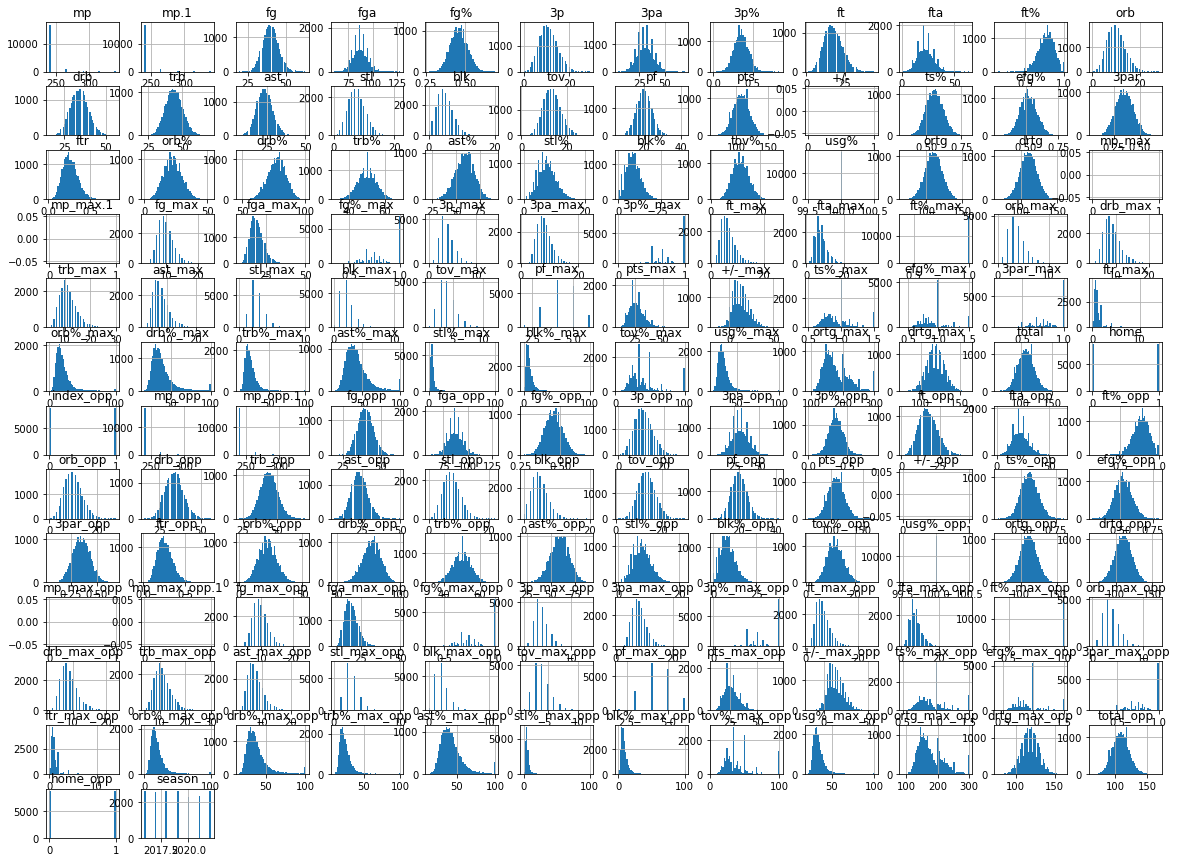

In [6]:
df_team_preprocess = pd.read_csv("nba_games.csv", index_col=0)
check_data_quality(df_team_preprocess) 

In [7]:
df_team_preprocess = df_team_preprocess.sort_values("date")
df_team_preprocess = df_team_preprocess.reset_index(drop=True)


df_team_preprocess = df_team_preprocess.drop(["mp.1", "mp_opp.1", "index_opp"], axis=1)


df_team_preprocess = make_last(['team', 'home'], df_team_preprocess)


won = df_team_preprocess['won']
del df_team_preprocess["won"]
won = won.map({True: 1, False: 0, np.nan: 2})
df_team_preprocess["won"] = won


nulls = pd.isnull(df_team_preprocess).sum()
nulls = nulls[nulls > 0]
valid_columns = df_team_preprocess.columns[~df_team_preprocess.columns.isin(nulls.index)]
df_team_preprocess = df_team_preprocess[valid_columns]

In [8]:
df_player_preprocess.head()

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,team_opp,won,target,season,player,team,GAME_DATE
171733,8.325000,2,4,0.500,0,1,0.000,1,1,1.00,1,1,2,0,0,0,0,0,2,1,5,-18,7.4,0,0,7.0,1,13060,13060,13060,23177,15070,18194,8149,12221,14538,12221,10567,13324,1,6171,17700,15902,18531,16648,12237,7994,1,11770,12086,16895,24878,21185,2032,118,20990,POR,0,1.0,2016-17,Dante Exum,UTA,2016-10-25
171681,17.850000,4,9,0.444,3,5,0.600,0,0,0.00,0,1,1,5,0,4,0,0,1,0,11,35,31.7,0,0,28.0,1,1,1,1,17741,8702,8880,12539,1368,3567,2920,13946,14843,13946,12923,17700,19668,2448,16648,118,7994,1,5176,18615,9213,38,5092,2032,118,5975,GSW,1,1.0,2016-17,Patty Mills,SAS,2016-10-25
171682,3.166667,0,0,0.000,0,0,0.000,1,2,0.50,0,0,0,0,0,0,0,0,3,2,1,-8,1.0,0,0,1.0,1,13060,13060,13060,25102,22732,25027,22732,12221,18442,12221,10567,7939,10848,12923,22443,23356,18531,16648,12237,7994,1,17848,7572,23142,20002,25100,2032,118,24764,SAS,0,1.0,2016-17,Anderson Varejao,GSW,2016-10-25
171683,24.983333,6,15,0.400,2,6,0.333,9,12,0.75,2,10,12,2,2,3,0,1,3,10,23,24,47.4,1,0,45.0,1,1,1,1,11749,4424,2883,14323,3010,2314,7723,384,245,8278,3010,526,772,8113,4192,414,7994,17509,17848,70,1876,492,1146,1,118,1154,NYK,1,1.0,2016-17,Kevin Love,CLE,2016-10-25
171684,20.083333,1,1,1.000,0,0,0.000,0,0,0.00,1,2,3,1,3,0,0,0,2,3,2,-3,4.1,0,0,6.0,1,13060,13060,13060,15885,18863,23566,1,12221,18442,12221,13946,14843,13946,6171,13221,12475,12386,1865,12237,7994,1,11770,4543,21017,15364,23357,2032,118,21660,SAS,0,1.0,2016-17,Zaza Pachulia,GSW,2016-10-25


In [9]:
df_team_preprocess.head()

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,ts%,efg%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ortg,drtg,fg_max,fga_max,fg%_max,3p_max,3pa_max,3p%_max,ft_max,fta_max,ft%_max,orb_max,drb_max,trb_max,ast_max,stl_max,blk_max,tov_max,pf_max,pts_max,+/-_max,ts%_max,efg%_max,3par_max,ftr_max,orb%_max,drb%_max,trb%_max,ast%_max,stl%_max,blk%_max,tov%_max,usg%_max,ortg_max,drtg_max,total,mp_opp,fg_opp,fga_opp,fg%_opp,3p_opp,3pa_opp,3p%_opp,ft_opp,fta_opp,ft%_opp,orb_opp,drb_opp,trb_opp,ast_opp,stl_opp,blk_opp,tov_opp,pf_opp,pts_opp,ts%_opp,efg%_opp,3par_opp,ftr_opp,orb%_opp,drb%_opp,trb%_opp,ast%_opp,stl%_opp,blk%_opp,tov%_opp,usg%_opp,ortg_opp,drtg_opp,fg_max_opp,fga_max_opp,fg%_max_opp,3p_max_opp,3pa_max_opp,3p%_max_opp,ft_max_opp,fta_max_opp,ft%_max_opp,orb_max_opp,drb_max_opp,trb_max_opp,ast_max_opp,stl_max_opp,blk_max_opp,tov_max_opp,pf_max_opp,pts_max_opp,+/-_max_opp,ts%_max_opp,efg%_max_opp,3par_max_opp,ftr_max_opp,orb%_max_opp,drb%_max_opp,trb%_max_opp,ast%_max_opp,stl%_max_opp,blk%_max_opp,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,team,home,won
0,240.0,35.0,83.0,0.422,6.0,18.0,0.333,19.0,27.0,0.704,8.0,25.0,33.0,21.0,9.0,3.0,18.0,26.0,95.0,0.501,0.458,0.217,0.325,18.6,54.3,37.1,60.0,9.0,4.5,15.9,100.0,94.9,110.9,7.0,20.0,1.000,2.0,7.0,0.667,10.0,15.0,1.0,3.0,5.0,6.0,9.0,3.0,3.0,5.0,5.0,18.0,5.0,1.000,1.000,1.000,0.750,19.8,26.3,13.6,43.4,5.3,6.3,37.5,38.9,201.0,120.0,95,240.0,41.0,96.0,0.427,9.0,30.0,0.300,20.0,22.0,0.909,21.0,35.0,56.0,29.0,8.0,7.0,20.0,29.0,111.0,0.525,0.474,0.313,0.229,45.7,81.4,62.9,70.7,8.0,10.8,15.9,100.0,110.9,94.9,14.0,26.0,1.000,5.0,12.0,1.000,7.0,7.0,1.0,5.0,5.0,9.0,7.0,2.0,2.0,7.0,5.0,40.0,20.0,1.136,1.000,0.462,0.571,39.0,27.2,25.2,50.1,19.1,7.9,69.4,43.7,206.0,104.0,GSW,111,1,2016,2015-10-27,NOP,0,0
1,240.0,38.0,94.0,0.404,9.0,29.0,0.310,10.0,17.0,0.588,11.0,39.0,50.0,26.0,5.0,7.0,10.0,21.0,95.0,0.468,0.452,0.309,0.181,21.6,84.8,51.5,68.4,5.0,10.3,9.0,100.0,95.5,97.5,12.0,22.0,0.571,3.0,7.0,0.500,3.0,4.0,1.0,4.0,10.0,12.0,7.0,1.0,2.0,3.0,4.0,25.0,9.0,0.714,0.714,1.000,2.000,10.8,41.9,23.8,31.2,2.8,18.5,30.4,29.0,138.0,105.0,95,240.0,37.0,87.0,0.425,7.0,19.0,0.368,16.0,23.0,0.696,7.0,40.0,47.0,13.0,6.0,10.0,13.0,22.0,97.0,0.499,0.466,0.218,0.264,15.2,78.4,48.5,35.1,6.0,15.4,11.8,100.0,97.5,95.5,8.0,22.0,0.750,3.0,5.0,0.750,5.0,5.0,1.0,2.0,8.0,10.0,5.0,2.0,6.0,4.0,6.0,19.0,9.0,0.820,0.875,0.556,1.333,12.2,38.5,26.0,30.3,2.8,14.0,53.2,34.6,162.0,104.0,CHI,97,1,2016,2015-10-27,CLE,0,0
2,240.0,37.0,87.0,0.425,7.0,19.0,0.368,16.0,23.0,0.696,7.0,40.0,47.0,13.0,6.0,10.0,13.0,22.0,97.0,0.499,0.466,0.218,0.264,15.2,78.4,48.5,35.1,6.0,15.4,11.8,100.0,97.5,95.5,8.0,22.0,0.750,3.0,5.0,0.750,5.0,5.0,1.0,2.0,8.0,10.0,5.0,2.0,6.0,4.0,6.0,19.0,9.0,0.820,0.875,0.556,1.333,12.2,38.5,26.0,30.3,2.8,14.0,53.2,34.6,162.0,104.0,97,240.0,38.0,94.0,0.404,9.0,29.0,0.310,10.0,17.0,0.588,11.0,39.0,50.0,26.0,5.0,7.0,10.0,21.0,95.0,0.468,0.452,0.309,0.181,21.6,84.8,51.5,68.4,5.0,10.3,9.0,100.0,95.5,97.5,12.0,22.0,0.571,3.0,7.0,0.500,3.0,4.0,1.0,4.0,10.0,12.0,7.0,1.0,2.0,3.0,4.0,25.0,9.0,0.714,0.714,1.000,2.000,10.8,41.9,23.8,31.2,2.8,18.5,30.4,29.0,138.0,105.0,CLE,95,0,2016,2015-10-27,CHI,1,1
3,240.0,41.0,96.0,0.427,9.0,30.0,0.300,20.0,22.0,0.909,21.0,35.0,56.0,29.0,8.0,7.0,20.0,29.0,111.0,0.525,0.474,0.313,0.229,45.7,81.4,62.9,70.7,8.0,10.8,15.9,100.0,110.9,94.9,14.0,26.0,1.000,5.0,12.0,1.000,7.0,7.0,1.0,5.0,5.0,9.0,7.0,2.0,2.0,7.0,5.0,40.0,20.0,1.136,1.000,0.462,0.571,39.0,27.2,25.2,50.1,19.1,7.9,69.4,43.7,206.0,104.0,111,240.0,35.0,83.0,0.422,6.0,18.0,0.333,19.0,27.0,0.704,8.0,25.0,33.0,21.0,9.0,3.0,18.0,26.0,95.0,0.501,0.458,0.217,0.325,18.6,54.3,37.1,60.0,9.0,4.5,15.9,100.0,94.9,110.9,7.0,20.0,1.000,2.0,7.0,0.667,10.0,15.0,1.0,3.0,5.0,6.0,9.0,3.0,3.0,5.0,5.0,18.0,5.0,1.000,1.000,1.000,0.750,19.8,26.3,13.6,43.4,5.3,6.3,37.5,38.9,201.0,120.0,NOP,95,0,2016,2015-10-27,GSW,1,1
4,240.0,37.0,82.0,0.451,8.0,27.0,0.296,12.0,15.0,0.800,7.0,33.0,40.

# Start ML

In [10]:
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit


def backtest(data, model, predictors, start=2, step=1):
    all_predictions = []
    
    seasons = sorted(data["season"].unique())
    
    for i in range(start, len(seasons), step):
        season = seasons[i]
        train = data[data["season"] < season]
        test = data[data["season"] == season]
        
        model.fit(train[predictors], train["target"])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)



rr = RidgeClassifier(alpha=1)
split = TimeSeriesSplit(n_splits=3)
sfs = SequentialFeatureSelector(rr,
                                n_features_to_select=30, 
                                direction="forward",
                                cv=split,
                                n_jobs=1
                               )

In [11]:
df_player = df_player_preprocess

In [12]:
df_team = df_team_preprocess

In [13]:
removed_columns_player = ['season', 'player', 'team', 'GAME_DATE','team_opp', 'won', 'target']
selected_columns_player = df_player.columns[~df_player.columns.isin(removed_columns_player)]

scaler = MinMaxScaler()
df_player[selected_columns_player] = scaler.fit_transform(df_player[selected_columns_player])

In [14]:
#sfs.fit(df_player[selected_columns_player], df_player["target"])
#predictors_player = list(selected_columns_player[sfs.get_support()])

In [15]:
predictors_player = ['MIN',
 'FGA',
 'FG3M',
 'FTM',
 'FTA',
 'OREB',
 'DREB',
 'REB',
 'TOV',
 'BLK',
 'BLKA',
 'PFD',
 'PLUS_MINUS',
 'DD2',
 'TD3',
 'GP_RANK',
 'W_RANK',
 'L_RANK',
 'W_PCT_RANK',
 'FGA_RANK',
 'FG3M_RANK',
 'FG3A_RANK',
 'OREB_RANK',
 'REB_RANK',
 'AST_RANK',
 'BLK_RANK',
 'BLKA_RANK',
 'PFD_RANK',
 'PTS_RANK',
 'PLUS_MINUS_RANK']

In [16]:
predictions_player = backtest(df_player, rr, predictors_player)
accuracy_score(predictions_player["actual"], predictions_player["prediction"])

0.5339029860739154

In [17]:
removed_columns_team = ["season", "date", "won", "target", "team", "team_opp"]
selected_columns_team = df_team.columns[~df_team.columns.isin(removed_columns_team)]

scaler = MinMaxScaler()
df_team[selected_columns_team] = scaler.fit_transform(df_team[selected_columns_team])

# Improve the moudle

In [18]:
df_player_rolling = df_player[list(selected_columns_player) + ["season","player", "won","team"]]
df_team_rolling = df_team[list(selected_columns_team) + ["won", "team", "season"]]

In [19]:
def find_team_averages(player):
    rolling = player.rolling(10).mean()
    return rolling

df_player_rolling = df_player_rolling.groupby(["player", "season"], group_keys=False).apply(find_team_averages)
df_team_rolling = df_team_rolling.groupby(["team", "season"], group_keys=False).apply(find_team_averages)

In [20]:
rolling_cols_player = [f"{col}_10" for col in df_player_rolling.columns]
df_player_rolling.columns = rolling_cols_player
df_player = pd.concat([df_player, df_player_rolling], axis=1)


rolling_cols_team = [f"{col}_10" for col in df_team_rolling.columns]
df_team_rolling.columns = rolling_cols_team
df_team = pd.concat([df_team, df_team_rolling], axis=1)

df_player = df_player.dropna()
df_team = df_team.dropna()

In [21]:
def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

def add_col_player(df, col_name):
    return df.groupby("player", group_keys=False).apply(lambda x: shift_col(x, col_name))

def add_col_team(df, col_name):
    return df.groupby("team", group_keys=False).apply(lambda x: shift_col(x, col_name))

In [22]:
df_player["team_opp_next"] = add_col_player(df_player, "team_opp")
df_player["game_date_next"] = add_col_player(df_player, "GAME_DATE")

df_team["home_next"] = add_col_team(df_team, "home")
df_team["team_opp_next"] = add_col_team(df_team, "team_opp")
df_team["date_next"] = add_col_team(df_team, "date")

In [23]:
removed_columns_player = ['season', 'GAME_DATE', 'player', 'team', 'team_opp', 'game_date_next','team_opp', 'won', 'target']
removed_columns_team = ['season', 'date', 'home', 'team', 'home', 'team_opp','home_opp','home_next', 'team_opp_next', 'won']


df_player = make_last(removed_columns_player, df_player)
df_team = make_last(removed_columns_team, df_team)

In [24]:
df_player[df_player['player'] == 'Deni Avdija']

,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,NBA_FANTASY_PTS,DD2,TD3,WNBA_FANTASY_PTS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,MIN_10,FGM_10,FGA_10,FG_PCT_10,FG3M_10,FG3A_10,FG3_PCT_10,FTM_10,FTA_10,FT_PCT_10,OREB_10,DREB_10,REB_10,AST_10,TOV_10,STL_10,BLK_10,BLKA_10,PF_10,PFD_10,PTS_10,PLUS_MINUS_10,NBA_FANTASY_PTS_10,DD2_10,TD3_10,WNBA_FANTASY_PTS_10,GP_RANK_10,W_RANK_10,L_RANK_10,W_PCT_RANK_10,MIN_RANK_10,FGM_RANK_10,FGA_RANK_10,FG_PCT_RANK_10,FG3M_RANK_10,FG3A_RANK_10,FG3_PCT_RANK_10,FTM_RANK_10,FTA_RANK_10,FT_PCT_RANK_10,OREB_RANK_10,DREB_RANK_10,REB_RANK_10,AST_RANK_10,TOV_RANK_10,STL_RANK_10,BLK_RANK_10,BLKA_RANK_10,PF_RANK_10,PFD_RANK_10,PTS_RANK_10,PLUS_MINUS_RANK_10,NBA_FANTASY_PTS_RANK_10,DD2_RANK_10,TD3_RANK_10,WNBA_FANTASY_PTS_RANK_10,won_10,team_opp_next,season,GAME_DATE,player,team,game_date_next,team_opp,won,target
68007,0.526155,0.304348,0.340909,0.467,0.357143,0.375000,0.556,0.038462,0.034483,1.0,0.000000,0.217391,0.166667,0.20,0.000000,0.2,0.0,0.250,0.333333,0.052632,0.281690,0.460177,0.394470,0.0,0.0,0.393939,0.0,0.885823,0.885823,0.885823,0.203658,0.140207,0.117373,0.470581,0.029021,0.045388,0.240039,0.640575,0.757247,0.000000,0.845710,0.180837,0.275411,0.133886,0.851180,0.098242,0.870127,0.801439,0.418030,0.544710,0.131699,0.553753,0.104415,0.783715,1.000000,0.094475,0.390860,0.108696,0.127273,0.4552,0.114286,0.145833,0.4456,0.019231,0.027586,0.3000,0.023077,0.156522,0.130000,0.092,0.041667,0.11,0.03,0.0375,0.433333,0.042105,0.100000,0.503540,0.204885,0.0,0.0,0.178788,0.0,0.708659,0.708659,0.708659,0.434729,0.559053,0.556203,0.478197,0.478568,0.437703,0.433272,0.738227,0.707879,0.641436,0.735667,0.377583,0.433322,0.428503,0.652447,0.445100,0.691285,0.138756,0.511910,0.653224,0.570002,0.447548,0.470742,0.783715,1.000000,0.487948,0.2,PHX,2020-21,2021-01-09,Deni Avdija,WAS,2021-01-11,MIA,0,1.0
67691,0.329249,0.130435,0.136364,0.500,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.076923,0.173913,0.166667,0.04,0.166667,0.0,0.0,0.000,0.500000,0.000000,0.084507,0.522124,0.136406,0.0,0.0,0.121212,0.0,0.000000,0.000000,0.000000,0.548686,0.467781,0.508230,0.331642,0.884688,0.874047,0.884688,0.846696,0.847806,0.846696,0.397861,0.272140,0.275411,0.605026,0.216660,0.867980,0.870127,0.000000,0.622530,0.846581,0.593434,0.311309,0.626990,0.783715,1.000000,0.611878,0.377041,0.113043,0.136364,0.4052,0.100000,0.137500,0.3456,0.015385,0.020690,0.2500,0.030769,0.156522,0.133333,0.092,0.050000,0.10,0.03,0.0375,0.433333,0.021053,0.098592,0.493805,0.201382,0.0,0.0,0.174747,0.0,0.620076,0.620076,0.620076,0.458851,0.546174,0.530900,0.511361,0.539238,0.467339,0.521741,0.758839,0.748484,0.659396,0.690882,0.377583,0.423673,0.428503,0.628741,0.499088,0.691285,0.138756,0.511910,0.725832,0.574031,0.469653,0.479645,0.783715,1.000000,0.498268,0.3,BKN,2020-21,2021-01-11,Deni Avdija,WAS,2021-01-31,PHX,1,1.0
64825,0.260860,0.043478,0.090909,0.250,0.000000,0.083333,0.000,0.000000,0.000000,0.0,0.076923,0.043478,0.066667,0.00,0.000000,0.0,0.0,0.000,0.333333,0.000000,0.028169,0.415929,0.070968,0.0,0.0,0.040404,0.0,0.000000,0.000000,0.000000,0.653250,0.730609,0.637121,0.775143,0.884688,0.577682,0.884688,0.846696,0.847806,0.846696,0.397861,0.706813,0.612763,0.871399,0.851180,0.867980,0.870127,0.000000,0.418030,0.846581,0.795694,0.693779,0.773416,0.783715,1.000000,0.796290,0.378732,0.108696,0.140909,0.3302,0.092857,0.141667,0.2456,0.015385,0.017241,0.2500,0.038462,0.147826,0.130000,0.084,0.050000,0.10,0.03,0.0375,0.400000,0.015789,0.094366,0.492035,0.194747,0.0,0.0,0.167677,0.0,0.531494,0.531494,0.531494,0.456598,0.559578,0.518485,0.588875,0.575905,0.453513,0.610210,0.758839,0.757540,0.659396,0.646097,0.409205,0.43659

In [25]:
df_team[df_team['team'] == 'WAS']

,mp,fg,fga,fg%,3p,3pa,3p%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,ts%,efg%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ortg,drtg,fg_max,fga_max,fg%_max,3p_max,3pa_max,3p%_max,ft_max,fta_max,ft%_max,orb_max,drb_max,trb_max,ast_max,stl_max,blk_max,tov_max,pf_max,pts_max,+/-_max,ts%_max,efg%_max,3par_max,ftr_max,orb%_max,drb%_max,trb%_max,ast%_max,stl%_max,blk%_max,tov%_max,usg%_max,ortg_max,drtg_max,total,mp_opp,fg_opp,fga_opp,fg%_opp,3p_opp,3pa_opp,3p%_opp,ft_opp,fta_opp,ft%_opp,orb_opp,drb_opp,trb_opp,ast_opp,stl_opp,blk_opp,tov_opp,pf_opp,pts_opp,ts%_opp,efg%_opp,3par_opp,ftr_opp,orb%_opp,drb%_opp,trb%_opp,ast%_opp,stl%_opp,blk%_opp,tov%_opp,usg%_opp,ortg_opp,drtg_opp,fg_max_opp,fga_max_opp,fg%_max_opp,3p_max_opp,3pa_max_opp,3p%_max_opp,ft_max_opp,fta_max_opp,ft%_max_opp,orb_max_opp,drb_max_opp,trb_max_opp,ast_max_opp,stl_max_opp,blk_max_opp,tov_max_opp,pf_max_opp,pts_max_opp,+/-_max_opp,ts%_max_opp,efg%_max_opp,3par_max_opp,ftr_max_opp,orb%_max_opp,drb%_max_opp,trb%_max_opp,ast%_max_opp,stl%_max_opp,blk%_max_opp,tov%_max_opp,usg%_max_opp,ortg_max_opp,drtg_max_opp,total_opp,mp_10,fg_10,fga_10,fg%_10,3p_10,3pa_10,3p%_10,ft_10,fta_10,ft%_10,orb_10,drb_10,trb_10,ast_10,stl_10,blk_10,tov_10,pf_10,pts_10,ts%_10,efg%_10,3par_10,ftr_10,orb%_10,drb%_10,trb%_10,ast%_10,stl%_10,blk%_10,tov%_10,usg%_10,ortg_10,drtg_10,fg_max_10,fga_max_10,fg%_max_10,3p_max_10,3pa_max_10,3p%_max_10,ft_max_10,fta_max_10,ft%_max_10,orb_max_10,drb_max_10,trb_max_10,ast_max_10,stl_max_10,blk_max_10,tov_max_10,pf_max_10,pts_max_10,+/-_max_10,ts%_max_10,efg%_max_10,3par_max_10,ftr_max_10,orb%_max_10,drb%_max_10,trb%_max_10,ast%_max_10,stl%_max_10,blk%_max_10,tov%_max_10,usg%_max_10,ortg_max_10,drtg_max_10,total_10,mp_opp_10,fg_opp_10,fga_opp_10,fg%_opp_10,3p_opp_10,3pa_opp_10,3p%_opp_10,ft_opp_10,fta_opp_10,ft%_opp_10,orb_opp_10,drb_opp_10,trb_opp_10,ast_opp_10,stl_opp_10,blk_opp_10,tov_opp_10,pf_opp_10,pts_opp_10,ts%_opp_10,efg%_opp_10,3par_opp_10,ftr_opp_10,orb%_opp_10,drb%_opp_10,trb%_opp_10,ast%_opp_10,stl%_opp_10,blk%_opp_10,tov%_opp_10,usg%_opp_10,ortg_opp_10,drtg_opp_10,fg_max_opp_10,fga_max_opp_10,fg%_max_opp_10,3p_max_opp_10,3pa_max_opp_10,3p%_max_opp_10,ft_max_opp_10,fta_max_opp_10,ft%_max_opp_10,orb_max_opp_10,drb_max_opp_10,trb_max_opp_10,ast_max_opp_10,stl_max_opp_10,blk_max_opp_10,tov_max_opp_10,pf_max_opp_10,pts_max_opp_10,+/-_max_opp_10,ts%_max_opp_10,efg%_max_opp_10,3par_max_opp_10,ftr_max_opp_10,orb%_max_opp_10,drb%_max_opp_10,trb%_max_opp_10,ast%_max_opp_10,stl%_max_opp_10,blk%_max_opp_10,tov%_max_opp_10,usg%_max_opp_10,ortg_max_opp_10,drtg_max_opp_10,total_opp_10,home_opp_10,home_10,won_10,season_10,date_next,season,date,team,home,team_opp,home_opp,home_next,team_opp_next,won
376,0.0,0.431818,0.264706,0.521531,0.241379,0.227273,0.437055,0.302326,0.301587,0.649942,0.321429,0.425,0.408163,0.348837,0.454545,0.00,0.344828,0.361111,0.317308,0.480167,0.483301,0.310937,0.307305,0.440000,0.628571,0.567568,0.525036,0.516129,0.000000,0.380597,0.0,0.444566,0.419319,0.285714,0.095238,0.846154,0.142857,0.130435,1.000,0.28,0.257143,1.000000,0.307692,0.20,0.153846,0.304348,0.2,0.000000,0.181818,0.75,0.133333,0.560000,0.514,0.538319,0.50000,0.138735,0.192,0.241916,0.106711,0.561927,0.048,0.000,0.176101,0.059050,0.407583,0.388235,0.317308,0.0,0.386364,0.279412,0.447368,0.275862,0.333333,0.365796,0.325581,0.317460,0.666278,0.285714,0.350,0.326531,0.302326,0.136364,0.10,0.413793,0.305556,0.298077,0.436326,0.432220,0.443750,0.319899,0.371429,0.560000,0.432432,0.492132,0.156682,0.088312,0.440299,0.0,0.419319,0.444566,0.238095,0.238095,0.538462,0.285714,0.260870,0.571,0.12,0.085714,1.0,0.153846,0.50,0.346154,0.304348,0.1,0.181818,0.454545,0.50,0.166667,0.480000,0.265,0.307479,0.58375,0.043063,0.204,0.318563,0.141914,0.511468,0.017,0.044,0.213836,0.204108,0.270142,0.447059,0.298077,0.0,0.418182,0.327941,0.453828,0.293103,0.298485,0.431116,0.448837,0.411111,0.709802,0.321429,0.4300,0.412245,0.369767,0.400000,0.225,0.500000,0.425000,0.380769,0.469520,0.4

In [26]:
full_player = df_player.merge(df_player[rolling_cols_player + ["team_opp_next", "GAME_DATE", "team"]], 
                left_on=["team", "GAME_DATE"], 
                right_on=["team_opp_next", "GAME_DATE"])

full_team = df_team.merge(df_team[rolling_cols_team + ["team_opp_next", "date_next", "team"]],
                left_on=["team", "date_next"],
                right_on=["team_opp_next", "date_next"])

In [27]:
full = pd.merge(full_player, full_team, left_on=['team_x', 'GAME_DATE'], right_on=['team_x', 'date'])

full = make_last(list(full.columns[full.dtypes == "object"]), full)
full = make_last(['target'], full)

full = full.dropna(axis=1)
full = full.dropna()
full = full.rename(columns={'season_10_y': 'season'})

removed_columns = list(full.columns[full.dtypes == "object"]) + ['target']
selected_columns = full.columns[~full.columns.isin(removed_columns)]
removed_columns

['season_x',
 'GAME_DATE',
 'player',
 'team_x',
 'team_opp_x',
 'team_opp_next_y_x',
 'team_y_x',
 'date_next',
 'date',
 'team_opp_y',
 'team_opp_next_x_y',
 'team_opp_next_y_y',
 'team_y_y',
 'target']

In [28]:
#sfs.fit(full[selected_columns], full["target"])
#predictors = list(selected_columns[sfs.get_support()])

In [29]:
selected_columns = ['mp',
 'orb',
 'ast',
 'tov',
 'usg%',
 'pf_max',
 'trb%_max',
 'stl%_max',
 'mp_opp',
 'usg%_opp',
 'usg%_10_x',
 'ft%_max_10_x',
 '3par_max_10_x',
 'usg%_opp_10_x',
 'stl_max_opp_10_x',
 'won_10_x_x',
 'won_10_x_y',
 'home_next',
 'drb_10_y',
 'trb%_10_y',
 'usg%_10_y',
 'ft_max_10_y',
 'efg%_max_10_y',
 'tov%_max_10_y',
 'trb%_opp_10_y',
 'usg%_opp_10_y',
 'fga_max_opp_10_y',
 'fta_max_opp_10_y',
 'ft%_max_opp_10_y',
 'orb%_max_opp_10_y',
 'won_10_y_x',
 'won_10_y_y']

In [30]:
predictions = backtest(full, rr, selected_columns)
accuracy_score(predictions["actual"], predictions["prediction"])

0.6129989420219946

# K-Means

In [31]:
removed_cols = (list(full.columns[full.dtypes == "object"]) + ['target'])
selected_cols = full.columns[~full.columns.isin(removed_cols)]

kmeans = KMeans(n_clusters=20, n_init=10)
kmeans.fit(full[selected_cols])
pd.DataFrame(kmeans.cluster_centers_, columns=selected_cols).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
MIN,0.284646,0.513478,0.315980,0.512084,0.513568,0.320124,0.489224,0.239018,0.317939,0.305431,0.500299,0.245097,0.534579,0.272830,0.264146,0.513647,0.545881,0.491024,0.476742,0.280014
FGM,0.085186,0.268632,0.112426,0.245301,0.277802,0.105069,0.254146,0.070825,0.103511,0.108120,0.243330,0.065103,0.318662,0.083970,0.083576,0.255990,0.292938,0.248162,0.215285,0.079198
FGA,0.113126,0.278346,0.127905,0.280899,0.284863,0.133905,0.266058,0.087923,0.130576,0.122644,0.276713,0.091230,0.324306,0.101994,0.099971,0.294116,0.330168,0.259665,0.249937,0.106862
FG_PCT,0.377558,0.513564,0.434370,0.462190,0.521003,0.392994,0.507218,0.377381,0.392840,0.419665,0.466544,0.349160,0.522883,0.393096,0.388025,0.461274,0.471177,0.505509,0.457301,0.360116
FG3M,0.040396,0.112172,0.063530,0.091783,0.140885,0.054518,0.117092,0.031041,0.055096,0.061196,0.105022,0.028100,0.152492,0.039588,0.048839,0.123509,0.133335,0.111493,0.091407,0.034857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
total_opp_10_y,0.455205,0.402296,0.458379,0.402657,0.451193,0.444523,0.452204,0.429988,0.462049,0.460313,0.452945,0.433785,0.461249,0.403458,0.449960,0.456121,0.452379,0.405853,0.408019,0.404290
home_opp_10_y,0.493595,0.504371,0.504824,0.489949,0.504582,0.502558,0.492755,0.497175,0.504501,0.499160,0.509534,0.509159,0.501892,0.501094,0.510749,0.493945,0.498997,0.503935,0.500522,0.489433
home_10_y,0.506405,0.495629,0.495176,0.510051,0.495418,0.497442,0.507245,0.502825,0.495499,0.500840,0.490466,0.490841,0.498108,0.498906,0.489251,0.506055,0.501003,0.496065,0.499478,0.510567
won_10_y_y,0.510004,0.488769,0.506230,0.508821,0.501958,0.512979,0.492929,0.494107,0.515210,0.517326,0.498342,0.499142,0.507498,0.489451,0.505835,0.510034,0.515546,0.511902,0.494831,0.506207


In [32]:
full['grade'] = kmeans.labels_
full['grade'].value_counts()

7     41843
11    39511
5     35148
16    33005
17    32658
6     32641
12    32287
18    31981
9     30226
2     30097
8     29927
13    29890
19    29449
10    29180
1     27317
3     25688
4     25685
14    24746
0     22835
15    21443
Name: grade, dtype: int64

In [33]:
full[full['team_x'] == 'GSW']['grade'].value_counts()

7     3283
13    2099
17    1485
9     1409
14    1364
11    1357
6     1341
1     1234
15    1230
12    1058
0      986
4      983
8      873
16     810
5      711
10     649
18     459
2      417
19     286
3      182
Name: grade, dtype: int64

In [34]:
full[full['team_x'] == 'WAS']['grade'].value_counts()

5     2033
11    1625
10    1562
7     1264
1     1250
13    1249
9     1223
15    1174
8     1160
18    1138
6     1135
17    1110
2     1087
16    1086
12     955
0      950
19     907
3      877
4      786
14     576
Name: grade, dtype: int64

In [35]:
full[full['player'] == 'LeBron James']['grade'].value_counts()

12    375
1     286
16    249
17    202
3     125
4     114
10    113
6     106
18     84
15     63
Name: grade, dtype: int64

In [36]:
full[full['player'] == 'Stephen Curry']['grade'].value_counts()

1     286
6     243
12    206
16    180
4     178
17    172
10     94
3      38
18     34
5       2
Name: grade, dtype: int64

In [37]:
def add_target2(group):
    group["target"] = group["grade"].shift(-1)
    group["target"].fillna(21, inplace=True)
    return group


full = full.groupby("player", group_keys=False).apply(add_target2)

In [38]:
temp = full[full['player'] == 'Deni Avdija']
temp[['player', 'date', 'team_x', 'grade', 'target']].head(30)

,player,date,team_x,grade,target
410759,Deni Avdija,2021-01-09,WAS,16,16.0
410760,Deni Avdija,2021-01-09,WAS,16,16.0
410761,Deni Avdija,2021-01-09,WAS,16,16.0
410762,Deni Avdija,2021-01-09,WAS,16,16.0
410763,Deni Avdija,2021-01-09,WAS,16,16.0
410764,Deni Avdija,2021-01-09,WAS,16,16.0
410765,Deni Avdija,2021-01-09,WAS,16,16.0
410766,Deni Avdija,2021-01-09,WAS,16,9.0
421131,Deni Avdija,2021-01-31,WAS,9,8.0
422439,Deni Avdija,2021-02-02,WAS,8,9.0


In [40]:
predictions = backtest(full, rr,selected_cols)
accuracy_score(predictions["actual"], predictions["prediction"])

0.05214088537760897